# グラフオートエンコーダで図形の埋め込みを求めて類似度を求める

## データをグラフに変換

In [181]:
# 画像の輪郭をグラフに変換するための関数

import cv2
import numpy as np
import torch
from torch_geometric.data import Data


def extract_contours(img):
    # ノイズ除去のためのぼかし処理
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # 輪郭の検出
    contours, _ = cv2.findContours(cv2.bitwise_not(blurred), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    epsilon_factor = 0.002
    simplified_contours = []
    for contour in contours:
        # 輪郭の単純化
        epsilon = epsilon_factor * cv2.arcLength(contour, True)  # 単純化の精度（大きいほど単純化される）
        approx = cv2.approxPolyDP(contour, epsilon, True)

        simplified_contours.append(approx)
    return contours


def create_graph_from_contour(img_path, label):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    contours = extract_contours(img)

    # 輪郭点を収集
    all_points = []
    for contour in contours:
        for point in contour:
            x, y = point[0]
            all_points.append([x, y])

    # NumPy配列に変換
    all_points = np.array(all_points)

    # 最小座標と最大座標を計算
    min_x, min_y = np.min(all_points, axis=0)
    max_x, max_y = np.max(all_points, axis=0)

    # 正規化された点を格納するリスト
    normalized_points = []

    # 各点を正規化
    for point in all_points:
        x, y = point
        # 0除算を避けるためのチェック
        normalized_x = (x - min_x) / (max_x - min_x) if max_x != min_x else 0.5
        normalized_y = (y - min_y) / (max_y - min_y) if max_y != min_y else 0.5
        normalized_points.append([normalized_x, normalized_y])

    x = torch.tensor(normalized_points, dtype=torch.float)
    edge_index = []
    for i in range(len(normalized_points)):
        # (i + 1) % len(all_points) 最後の点のとき0になる（最初と最後を繋げる）
        edge_index.append([i, (i + 1) % len(normalized_points)])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))

In [182]:
# データ(画像)の読み込みと変換
import glob
import random
from torch_geometric.loader import DataLoader

labels = {"circle": 0, "square": 1, "star": 2, "triangle": 3}

dataset = []
for label in labels:
    image_paths = glob.glob(f"shapes/{label}/*")
    random.shuffle(image_paths)
    for path in image_paths[:100]:
        data = create_graph_from_contour(path, labels[label])
        dataset.append(data)

In [21]:
dataset[200].y

tensor([2])

In [130]:
dataset[200]

Data(x=[65, 2], edge_index=[2, 65], y=[1])

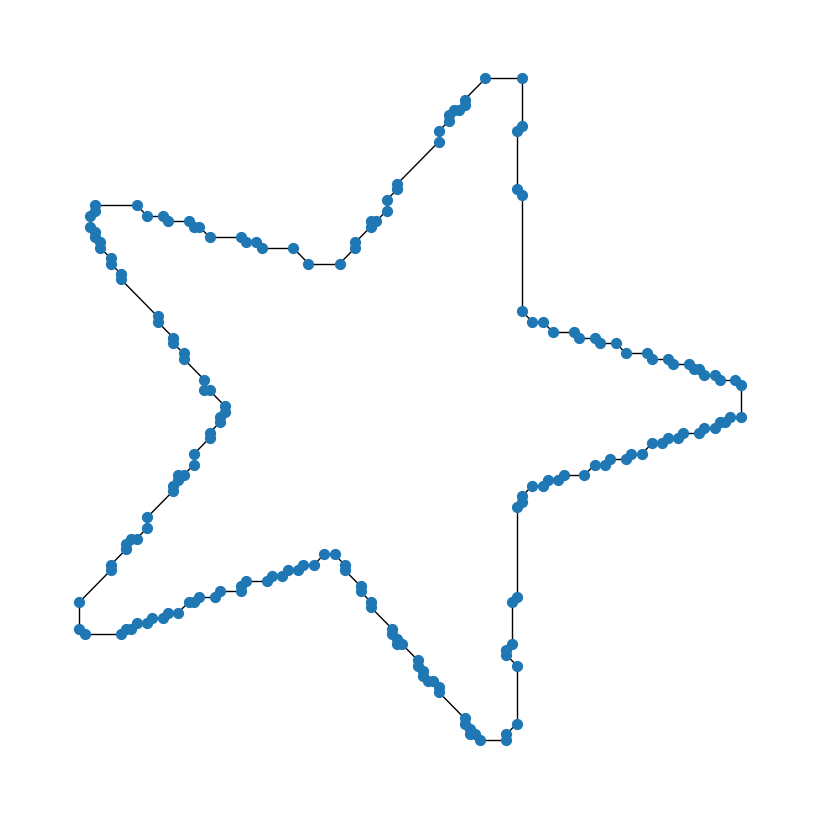

In [183]:
# グラフの可視化
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt

data = dataset[200]
G = torch_geometric.utils.convert.to_networkx(data, to_undirected=True)

# 最大連結成分のみ
largest_cc = max(nx.connected_components(G), key=len)
G_draw = G.subgraph(largest_cc)

# グラフ描画
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw, pos=data.x, with_labels=False, font_family="MS Gothic", node_size=50, font_size=9)
plt.show()

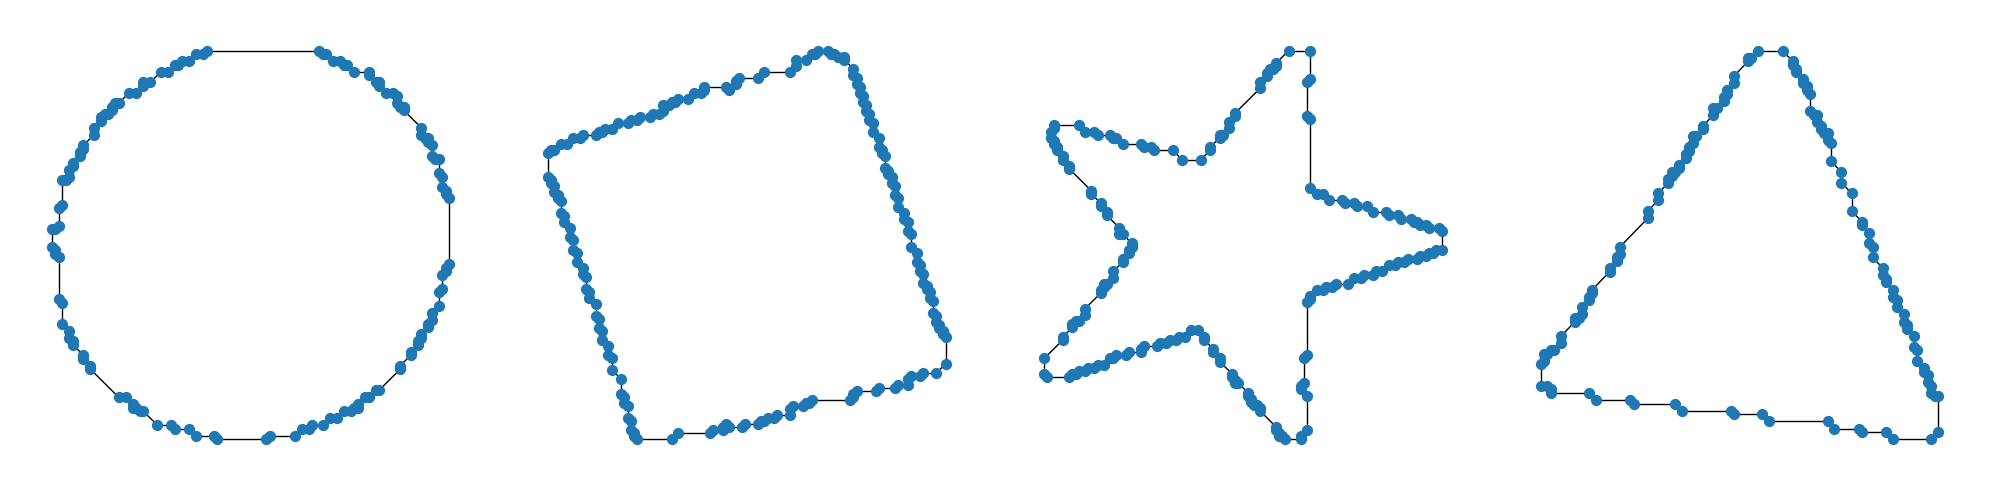

In [185]:
# 複数個描画してどんな感じのグラフがあるか見る
import random

# データセットからランダムに選択
count = 4
random_indices = (0, 100, 200, 320)

# 描画用のサブプロット作成
fig, axs = plt.subplots(1, count, figsize=(20, 5))  # 1行count列でcount個のグラフを表示

for i, idx in enumerate(random_indices):
    data = dataset[idx]
    G = torch_geometric.utils.convert.to_networkx(data, to_undirected=True)

    # グラフ描画
    nx.draw(G, pos=data.x.cpu(), with_labels=False, font_family="MS Gothic", node_size=50, font_size=9, ax=axs[i])  # axを指定してサブプロットに描画
    # axs[i].set_title(f'Graph {i+1} (Index: {idx})')

# 全体のレイアウト調整
plt.tight_layout()
plt.show()

In [150]:
# ミニバッチ処理
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False),
    T.ToDevice(device),
])

train_data_list = []
test_data_list = []

# データセットの各グラフに対してtransformを適用
for graph_data in dataset:
    train_data, val_data, test_data = transform(graph_data)
    train_data_list.append(train_data)
    test_data_list.append(test_data)

# DataLoaderの作成（複数のグラフを含むバッチ処理）
train_loader = DataLoader(train_data_list, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=128, shuffle=True)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 128
DataBatch(x=[20734, 2], edge_index=[2, 33196], y=[128], pos_edge_label=[16598], pos_edge_label_index=[2, 16598], batch=[20734], ptr=[129])

Step 2:
Number of graphs in the current batch: 128
DataBatch(x=[20963, 2], edge_index=[2, 33566], y=[128], pos_edge_label=[16783], pos_edge_label_index=[2, 16783], batch=[20963], ptr=[129])

Step 3:
Number of graphs in the current batch: 128
DataBatch(x=[20314, 2], edge_index=[2, 32536], y=[128], pos_edge_label=[16268], pos_edge_label_index=[2, 16268], batch=[20314], ptr=[129])

Step 4:
Number of graphs in the current batch: 16
DataBatch(x=[2718, 2], edge_index=[2, 4352], y=[16], pos_edge_label=[2176], pos_edge_label_index=[2, 2176], batch=[2718], ptr=[17])



## モデルの作成 & 訓練

In [151]:
# モデルの作成
import torch
from torch_geometric.nn import GCNConv, GAE, GraphSAGE
    
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GraphSAGE(in_channels, out_channels * 2, 2)
        self.conv2 = GraphSAGE(out_channels * 2, out_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    

# in_channels: 特徴量の次元数
# out_channels: 埋め込みの次元数
in_channels, out_channels = 2, 16
model = GAE(Encoder(in_channels, out_channels))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

GAE(
  (encoder): Encoder(
    (conv1): GraphSAGE(2, 32, num_layers=2)
    (conv2): GraphSAGE(32, 16, num_layers=2)
  )
  (decoder): InnerProductDecoder()
)


### 訓練

In [134]:
import torch_geometric.transforms as T

def train():
    model.train()
    optimizer.zero_grad()

    for batch_data in train_loader:  # バッチごとに複数のグラフが渡される
        z = model.encode(batch_data.x, batch_data.edge_index)
        loss = model.recon_loss(z, batch_data.pos_edge_label_index)

        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.


@torch.no_grad()
def test(loader):
    model.eval()
    total_auc = 0
    total_ap = 0
    total_samples = 0
    for batch_data in loader:  # バッチごとに複数のグラフが渡される
        z = model.encode(batch_data.x, batch_data.edge_index)
        
        auc, ap = model.test(z, batch_data.pos_edge_label_index, batch_data.neg_edge_label_index)
        
        # 重み付けを考慮して合計を更新
        total_auc += auc * batch_data.num_graphs
        total_ap += ap * batch_data.num_graphs
        total_samples += batch_data.num_graphs
    
    # 重み付け平均を返す
    return total_auc / total_samples, total_ap / total_samples

Epoch: 001, AUC: 0.7425, AP: 0.7046
Epoch: 002, AUC: 0.7613, AP: 0.7197
Epoch: 003, AUC: 0.7937, AP: 0.7607
Epoch: 004, AUC: 0.8068, AP: 0.7696
Epoch: 005, AUC: 0.8145, AP: 0.7754
Epoch: 006, AUC: 0.8155, AP: 0.7777
Epoch: 007, AUC: 0.8210, AP: 0.7896
Epoch: 008, AUC: 0.8267, AP: 0.7952
Epoch: 009, AUC: 0.8341, AP: 0.8090
Epoch: 010, AUC: 0.8455, AP: 0.8114
Epoch: 011, AUC: 0.8499, AP: 0.8223
Epoch: 012, AUC: 0.8579, AP: 0.8274
Epoch: 013, AUC: 0.8678, AP: 0.8414
Epoch: 014, AUC: 0.8697, AP: 0.8413
Epoch: 015, AUC: 0.8653, AP: 0.8388
Epoch: 016, AUC: 0.8682, AP: 0.8413
Epoch: 017, AUC: 0.8729, AP: 0.8417
Epoch: 018, AUC: 0.8760, AP: 0.8511
Epoch: 019, AUC: 0.8782, AP: 0.8529
Epoch: 020, AUC: 0.8816, AP: 0.8549
Epoch: 021, AUC: 0.8793, AP: 0.8466
Epoch: 022, AUC: 0.8846, AP: 0.8526
Epoch: 023, AUC: 0.8839, AP: 0.8502
Epoch: 024, AUC: 0.8825, AP: 0.8477
Epoch: 025, AUC: 0.8849, AP: 0.8569
Epoch: 026, AUC: 0.8818, AP: 0.8457
Epoch: 027, AUC: 0.8896, AP: 0.8607
Epoch: 028, AUC: 0.8909, AP:

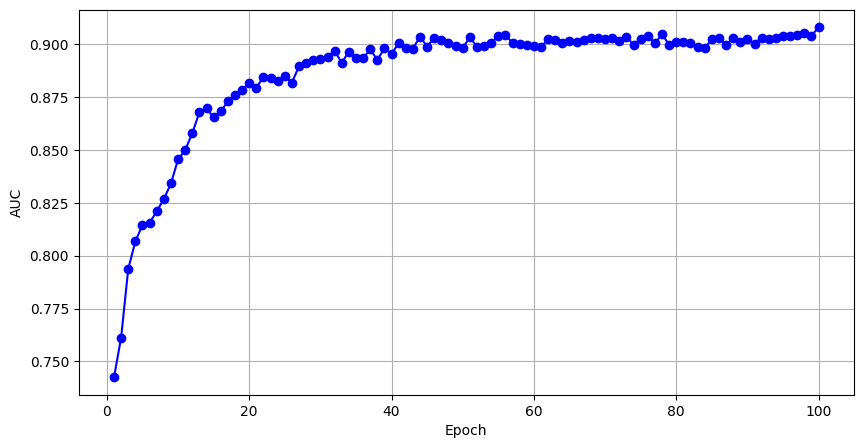

In [152]:
# 学習
import matplotlib.pyplot as plt

epochs = 100
auc_history = []
best_auc = 0
for epoch in range(1, epochs + 1):
    loss = train()
    mean_auc, mean_ap = test(test_loader)
    auc_history.append(mean_auc)
    print(f'Epoch: {epoch:03d}, AUC: {mean_auc:.4f}, AP: {mean_ap:.4f}')

    # 一番いいモデルを保存する
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_model_state = model.state_dict()  # モデルのパラメータを保存

# AUCの変化の可視化
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), auc_history, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

## 検証

In [153]:
# 一番いいモデルをロード
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [158]:
# 各グラフの埋め込みを求める
from torch_geometric.data.batch import Batch
from torch_geometric.nn import global_mean_pool, global_add_pool

dataset = [data.to(device) for data in dataset]
batch = Batch.from_data_list(dataset)

# ノード埋め込みの取得
z = model.encode(batch.x, batch.edge_index)


# グラフごとの埋め込みをプーリングして取得
graph_embeddings = global_add_pool(z, batch.batch)

with torch.no_grad():
	graph_embeddings = graph_embeddings.cpu().numpy()

graph_embeddings.shape

(400, 16)

### 埋め込みの可視化

In [138]:
# 描画する関数(クラスも可視化)
def plot_points(z, y, node_labels=None):
    """
    z: 埋め込み (2次元のテンソル or 配列)
    y: クラスラベル (各点のクラス、同じ長さの配列)
    node_labels: G.nodesを指定すればOK。何も指定しなければラベルを表示しない
    """

    plt.figure(figsize=(9, 9))

    # クラスラベルに基づいて色を変更
    plt.scatter(z[:, 0], z[:, 1], s=70, c=y, cmap='viridis', alpha=0.6)

    # ノードのラベルを表示
    if node_labels:
        for i, label in enumerate(node_labels):
            plt.text(z[i, 0], z[i, 1] + 0.08, label, fontsize=9, ha='center', va='center', fontname="MS Gothic")
    plt.axis('off')
    plt.show()

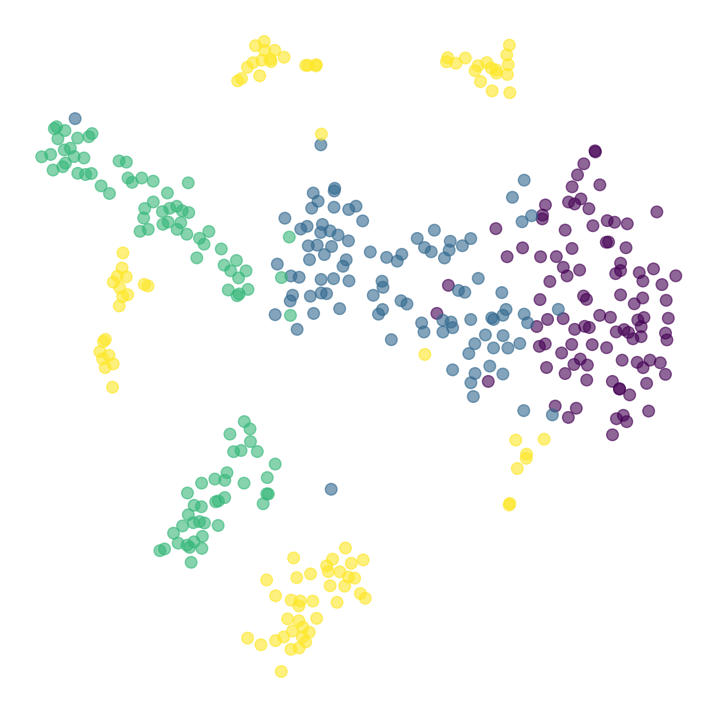

In [186]:
# TSNEを使うパターン
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

y = [data.y.cpu() for data in dataset]

z_transformed = TSNE(n_components=2).fit_transform(graph_embeddings)
plot_points(z_transformed, y)

### 類似度を求める

In [163]:
# 指定したグラフの類似度ランキングを求める
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def get_similar_ranking(graph_index, euc_dist):
    # 指定したグラフの距離を取得
    distances = euc_dist[graph_index]
    
    # 自分自身を除外するために距離を無限大に設定
    distances[graph_index] = np.inf
    
    # 距離が小さい順にソートし、インデックスを取得
    return np.argsort(distances)

# 各グラフ間の類似度(ユークリッド距離)を求める
euc_dist = euclidean_distances(graph_embeddings)

# 指定したグラフのインデックス
specified_graph_index = 200

ranking = get_similar_ranking(specified_graph_index, euc_dist)

print("Top 5 similar graphs to graph index", specified_graph_index, ":", ranking[:5])

Top 5 similar graphs to graph index 200 : [279 204 216 268 211]


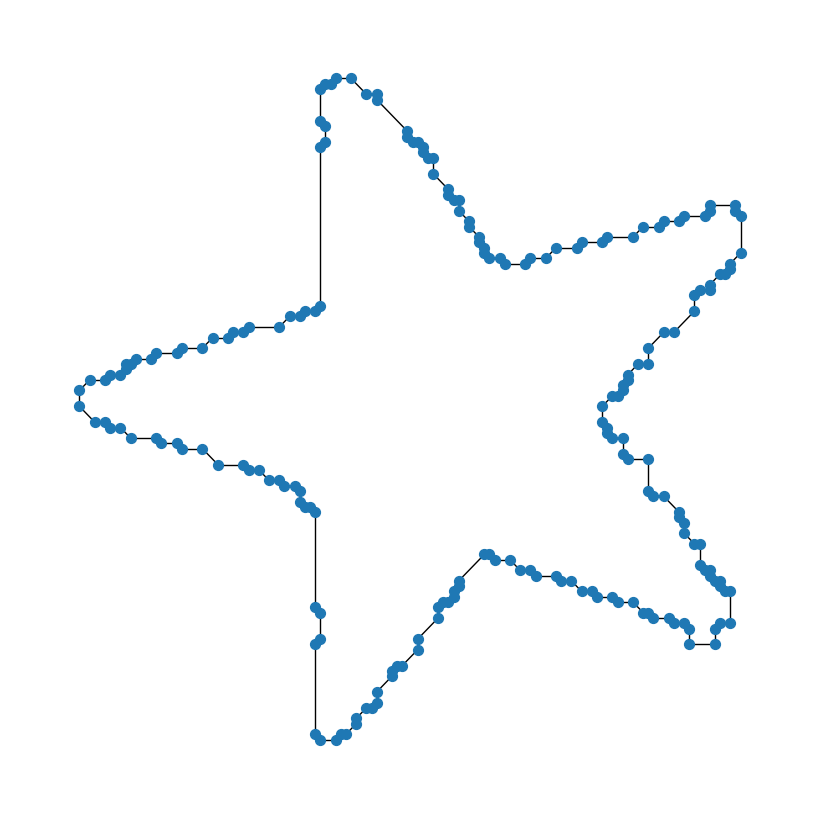

In [164]:
# グラフの可視化
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt

data = dataset[specified_graph_index]
G = torch_geometric.utils.convert.to_networkx(data, to_undirected=True)

# 最大連結成分のみ
largest_cc = max(nx.connected_components(G), key=len)
G_draw = G.subgraph(largest_cc)

# グラフ描画
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw, pos=data.x.cpu(), with_labels=False, font_family="MS Gothic", node_size=50, font_size=9)
plt.show()

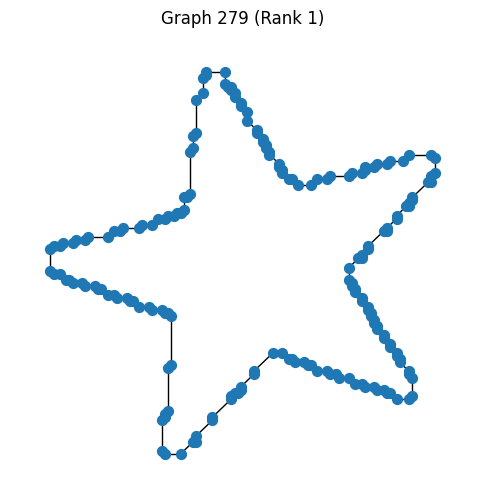

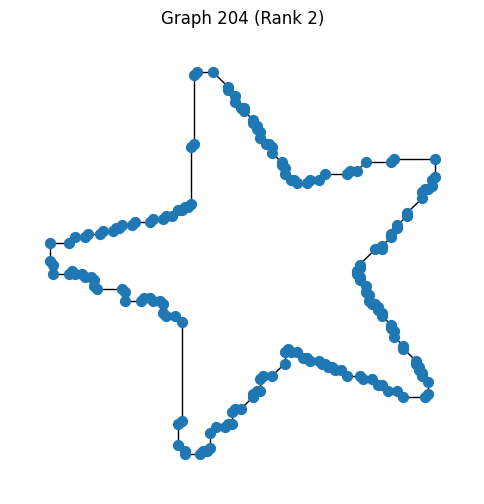

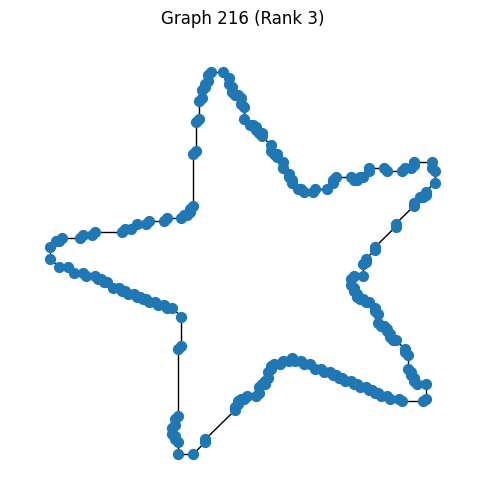

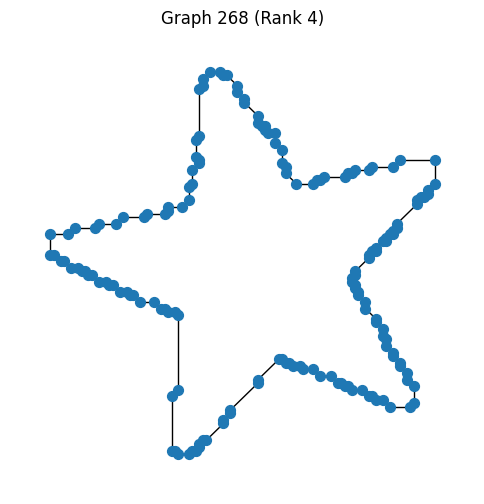

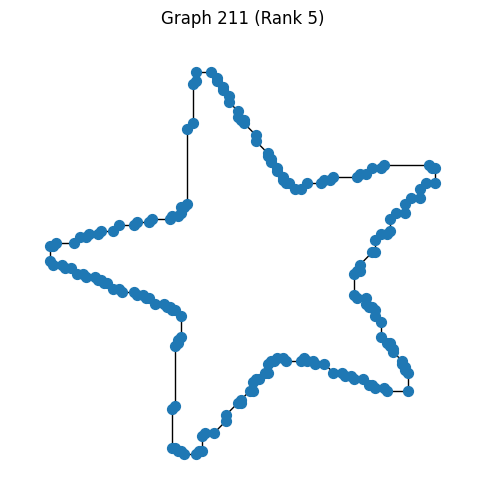

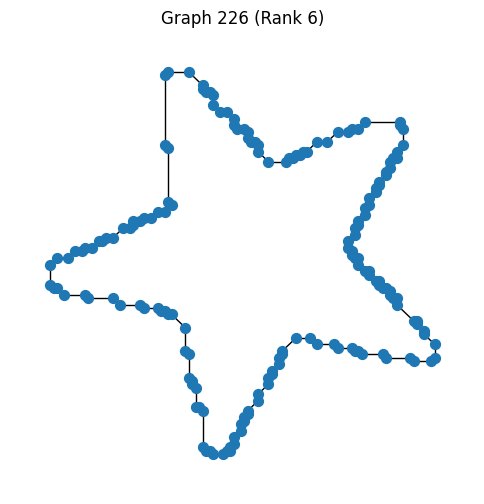

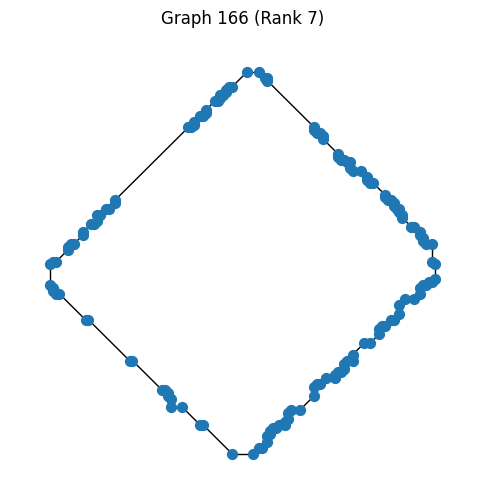

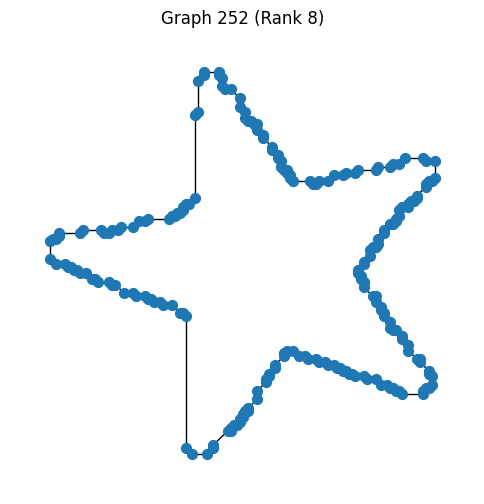

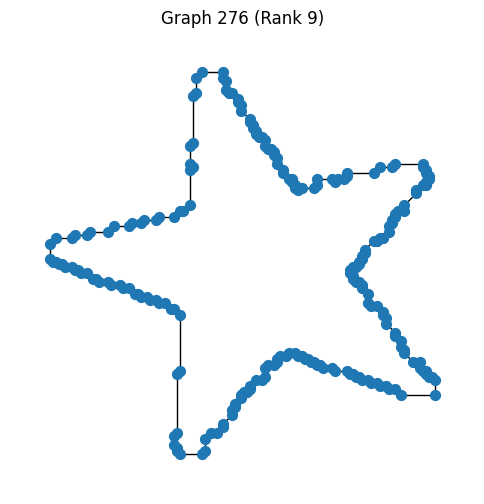

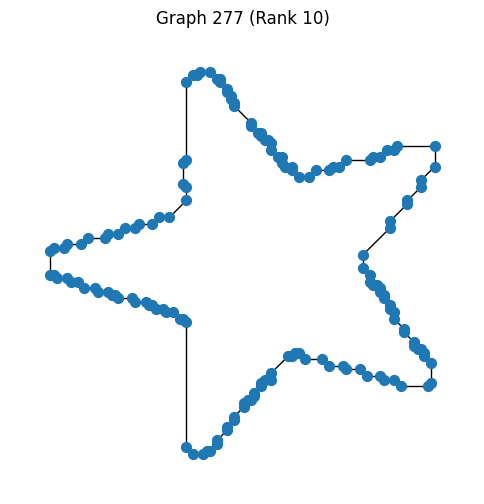

In [165]:
# 類似度トップのグラフを描画

def draw_graphs(graph_indices, dataset):
    for i, graph_idx in enumerate(graph_indices):
        G = torch_geometric.utils.convert.to_networkx(dataset[graph_idx], to_undirected=True)
        
        node_features = dataset[graph_idx].x.cpu().numpy()

        # グラフ描画
        plt.figure(figsize=(6, 6))
        plt.title(f'Graph {graph_idx} (Rank {i + 1})')
        nx.draw(G, pos=node_features, with_labels=False, font_family="MS Gothic", node_size=50, font_size=9)
        plt.show()

# 例として、類似度が高いグラフのインデックスを用意
top_k_graph_indices = ranking[:10]

# 描画
draw_graphs(top_k_graph_indices, dataset)

In [166]:
# 類似度
for i in top_k_graph_indices:
	print(euc_dist[specified_graph_index][i])

17.437193
21.104805
21.311123
22.391357
24.10952
24.27158
24.759487
25.176617
27.869781
31.647436


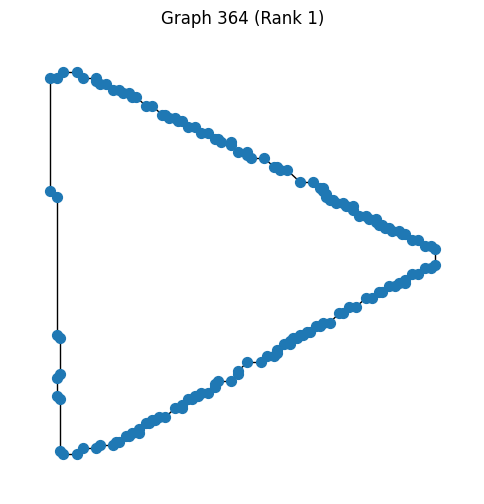

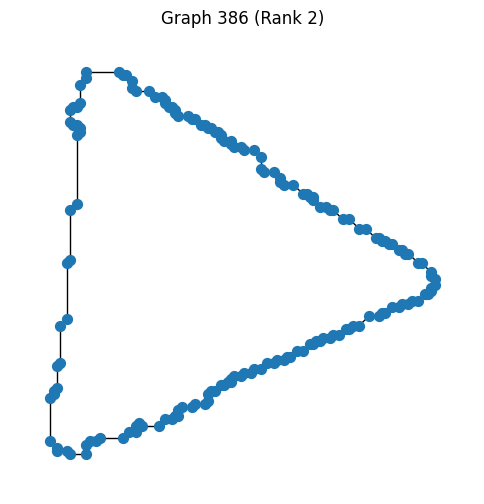

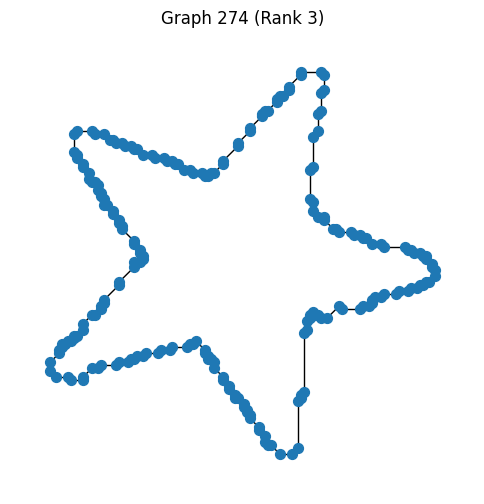

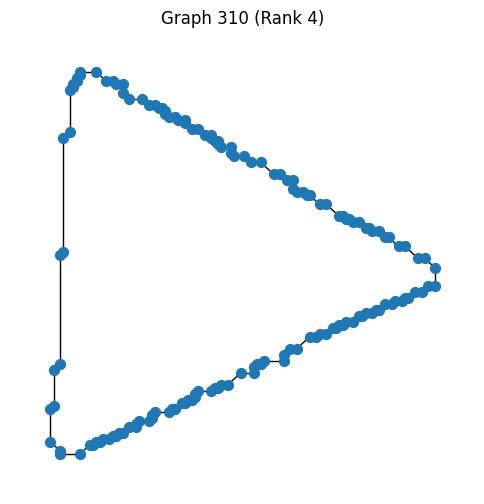

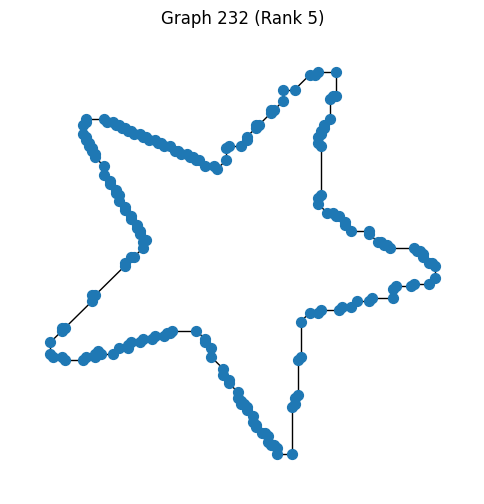

In [167]:
# 類似度ワーストのグラフを描画

top_k_graph_indices = ranking[-6:-1]

# 描画
draw_graphs(top_k_graph_indices, dataset)

## MLPと比較

In [77]:
import torch
import torch.nn as nn

# MLPエンコーダー
class MLPEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 2層のMLPエンコーダー
        self.fc1 = nn.Linear(in_channels, out_channels * 2)
        self.fc2 = nn.Linear(out_channels * 2, out_channels)

    def forward(self, x):
        # ノード特徴量だけを用いてエンコーディング
        x = self.fc1(x).relu()
        return self.fc2(x)

# MLPデコーダー
class MLPDecoder(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        # 2層のMLPデコーダー
        self.fc1 = nn.Linear(out_channels, out_channels * 2)
        self.fc2 = nn.Linear(out_channels * 2, in_channels)

    def forward(self, z):
        # 埋め込みベクトルを復元
        z = self.fc1(z).relu()
        return self.fc2(z)

# オートエンコーダーモデル
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = MLPEncoder(in_channels, out_channels)
        self.decoder = MLPDecoder(out_channels, in_channels)

    def forward(self, x):
        # エンコードしてからデコード
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# 特徴量の次元数 (例: ノードの位置情報を2次元として)
in_channels = 2
# 埋め込みの次元数 (出力空間の次元)
out_channels = 16

# AutoEncoderモデルの作成
model = AutoEncoder(in_channels, out_channels)
model = model.to(device)

# オプティマイザーの設定
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)


AutoEncoder(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): MLPDecoder(
    (fc1): Linear(in_features=16, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [85]:
# トレーニング関数
def train():
    model.train()
    total_loss = 0

    for batch_data in train_loader:  # バッチごとにデータを処理
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        
        # 特徴量の復元と埋め込み
        x_hat, z = model(batch_data.x)
        
        # 復元誤差 (MSE loss)
        loss = nn.MSELoss()(x_hat, batch_data.x)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# テスト関数（埋め込みを取得する場合）
@torch.no_grad()
def test(loader):
    model.eval()
    total_loss = 0
    embeddings = []

    for batch_data in loader:
        batch_data = batch_data.to(device)
        
        # 特徴量の復元と埋め込み
        x_hat, z = model(batch_data.x)
        
        # 埋め込みを保存
        embeddings.append(z.cpu().numpy())
        
        # 復元誤差 (MSE loss)
        loss = nn.MSELoss()(x_hat, batch_data.x)
        total_loss += loss.item()

    # 全てのバッチの埋め込みを返す
    return total_loss / len(loader), embeddings

# トレーニングとテストの実行例
for epoch in range(100):
    train_loss = train()
    test_loss, embeddings = test(test_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1, Train Loss: 0.0707, Test Loss: 0.0487
Epoch 2, Train Loss: 0.0388, Test Loss: 0.0255
Epoch 3, Train Loss: 0.0166, Test Loss: 0.0072
Epoch 4, Train Loss: 0.0068, Test Loss: 0.0052
Epoch 5, Train Loss: 0.0066, Test Loss: 0.0049
Epoch 6, Train Loss: 0.0037, Test Loss: 0.0017
Epoch 7, Train Loss: 0.0018, Test Loss: 0.0016
Epoch 8, Train Loss: 0.0021, Test Loss: 0.0018
Epoch 9, Train Loss: 0.0017, Test Loss: 0.0009
Epoch 10, Train Loss: 0.0007, Test Loss: 0.0006
Epoch 11, Train Loss: 0.0006, Test Loss: 0.0008
Epoch 12, Train Loss: 0.0007, Test Loss: 0.0005
Epoch 13, Train Loss: 0.0004, Test Loss: 0.0002
Epoch 14, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 15, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 16, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 17, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 18, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 19, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 20, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 21, Train Loss: 0.0001, Test Loss: 0.0001
E

In [86]:
# 各グラフの埋め込みを求める
from torch_geometric.data.batch import Batch
from torch_geometric.nn import global_mean_pool

dataset = [data.to(device) for data in dataset]
batch = Batch.from_data_list(dataset)

# ノード埋め込みの取得
x_hat, z = model(batch.x)

# グラフごとの埋め込みをプーリングして取得
graph_embeddings = global_mean_pool(z, batch.batch)

# graph_embeddings = global_mean_pool(batch.x, batch.batch)

with torch.no_grad():
	graph_embeddings = graph_embeddings.cpu().numpy()

graph_embeddings.shape

(400, 16)

In [87]:
graph_embeddings

array([[-0.0769861 ,  0.29847333,  0.31142554, ..., -0.58716655,
         0.13708143, -0.2612899 ],
       [-0.08186958,  0.3014335 ,  0.3175703 , ..., -0.59207857,
         0.13440058, -0.25468877],
       [-0.10219947,  0.32174373,  0.34682083, ..., -0.62542737,
         0.14480524, -0.2539803 ],
       ...,
       [-0.07218114,  0.28745797,  0.30120072, ..., -0.57586336,
         0.14405659, -0.22315983],
       [-0.09582461,  0.31883898,  0.3473996 , ..., -0.6287871 ,
         0.15845965, -0.26439047],
       [-0.10552169,  0.31696463,  0.34750733, ..., -0.6285333 ,
         0.1615874 , -0.20884797]], dtype=float32)

In [88]:
batch.x[:10]

tensor([[0.4159, 0.0000],
        [0.3982, 0.0180],
        [0.3451, 0.0180],
        [0.3363, 0.0270],
        [0.3097, 0.0270],
        [0.2920, 0.0450],
        [0.2832, 0.0450],
        [0.2743, 0.0541],
        [0.2655, 0.0541],
        [0.2478, 0.0721]], device='cuda:0')

In [89]:
x_hat[:10]

tensor([[0.4161, 0.0031],
        [0.3986, 0.0204],
        [0.3443, 0.0181],
        [0.3361, 0.0273],
        [0.3084, 0.0255],
        [0.2919, 0.0439],
        [0.2827, 0.0434],
        [0.2744, 0.0526],
        [0.2652, 0.0520],
        [0.2487, 0.0704]], device='cuda:0', grad_fn=<SliceBackward0>)

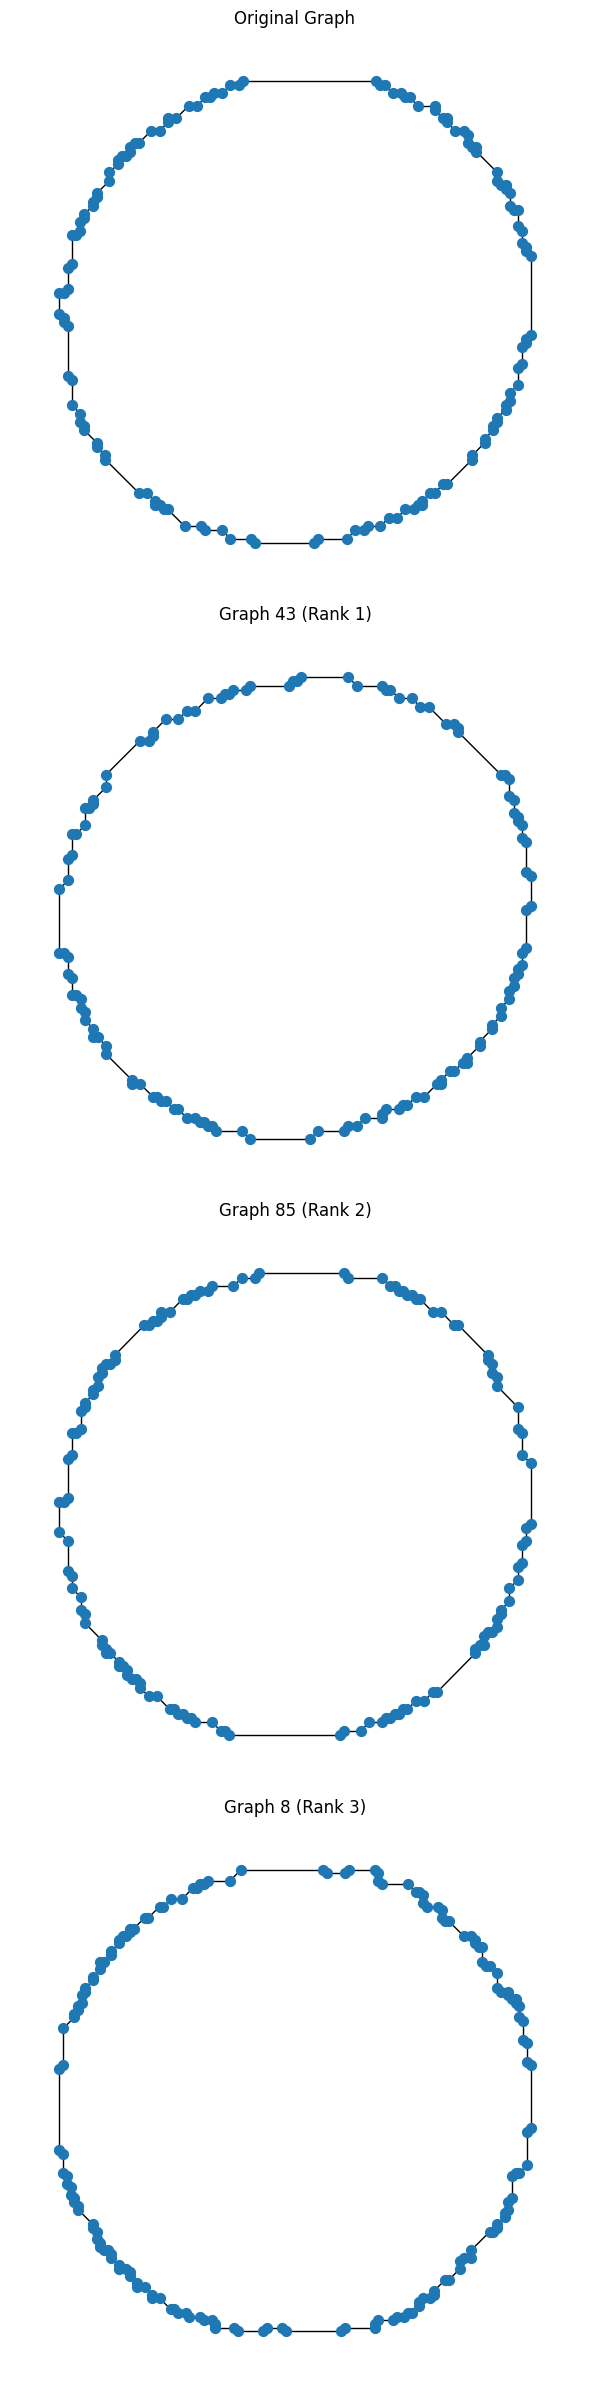

In [191]:
# 類似度ランキングを見やすく描画
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def draw_graphs(original_graph_idx, top_k_graph_indices, dataset):
    # グラフ数に応じたサブプロットの行数
    num_graphs = len(top_k_graph_indices) + 1  # 元のグラフ + ランキングされたグラフ
    fig, axs = plt.subplots(num_graphs, 1, figsize=(6, 6 * num_graphs))  # 各グラフが縦に並ぶように設定

    # 元のグラフを描画
    G_original = torch_geometric.utils.convert.to_networkx(dataset[original_graph_idx], to_undirected=True)
    node_features_original = dataset[original_graph_idx].x.cpu().numpy()
    
    axs[0].set_title(f'Original Graph')
    nx.draw(G_original, pos=node_features_original, with_labels=False, font_family="MS Gothic", 
            node_size=50, font_size=9, ax=axs[0])

    # 類似度トップのグラフを描画
    for i, graph_idx in enumerate(top_k_graph_indices):
        G = torch_geometric.utils.convert.to_networkx(dataset[graph_idx], to_undirected=True)
        node_features = dataset[graph_idx].x.cpu().numpy()

        axs[i + 1].set_title(f'Graph {graph_idx} (Rank {i + 1})')
        nx.draw(G, pos=node_features, with_labels=False, font_family="MS Gothic", 
                node_size=50, font_size=9, ax=axs[i + 1])

    plt.tight_layout()
    plt.show()

original_graph_idx = 0

ranking = get_similar_ranking(original_graph_idx, euc_dist)

# 例として、元のグラフと類似度が高いグラフのインデックスを用意
top_k_graph_indices = ranking[:3]  # 類似度が高いトップ5グラフのインデックス

# 描画
draw_graphs(original_graph_idx, top_k_graph_indices, dataset)

# レガシー

In [148]:
test_data = []
for label in labels:
    image_paths = glob.glob(f"shapes/circle/*")
    for path in image_paths[600:610]:
        data = create_graph_from_contour(path, labels[label])
        test_data.append(data)

In [209]:
test_data = [
	create_graph_from_contour("shikaku.png", 1),
	create_graph_from_contour("circle.png", 0),
	create_graph_from_contour("star.png", 2),
	create_graph_from_contour("triangle.png", 3)
]

In [45]:
test_data = [
	create_graph_from_contour("ori_c.png", 0),
	create_graph_from_contour("ori_sq.png", 1),
	create_graph_from_contour("ori_star.png", 2),
	create_graph_from_contour("ori_t.png", 3),
]

[[0.00951601 0.02261642]]


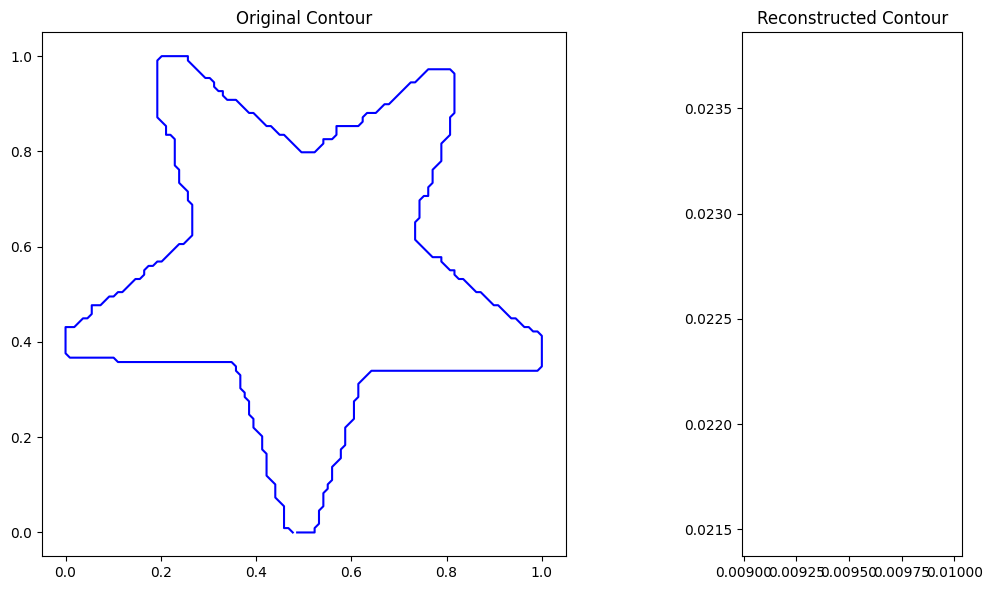

In [53]:
import matplotlib.pyplot as plt

# 再構成と可視化の関数
def reconstruct_and_visualize(model, data, original_shape):
    model.eval()
    with torch.no_grad():
        reconstructed, _ = model(data.x, data.edge_index, data.batch)
    
    # 元のデータと再構成されたデータをnumpy配列に変換
    original = data.x.numpy()
    reconstructed = reconstructed.numpy()
    print(reconstructed)
    
    # 元の形状に戻す
    original = original.reshape(original_shape)
    
    # 可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(original[:, 0], original[:, 1], 'b-')
    ax1.set_title('Original Contour')
    ax1.set_aspect('equal')
    
    ax2.plot(reconstructed[:, 0], reconstructed[:, 1], 'r-')
    ax2.set_title('Reconstructed Contour')
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# 使用例
# data はPyTorch Geometric のData オブジェクト
# original_shape は元の輪郭データの形状 (例: (100, 2) - 100点の x, y 座標)
i = 2
reconstruct_and_visualize(model, test_data[i], original_shape=test_data[i].x.shape)